In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-97b6a51f-8d61-7d11-0940-c55d2578926e)


In [2]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install DALL-E
!pip install ftfy
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 13 kB/s 
     |████████████████████████████████| 12.8 MB 70 kB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=6ec58375b88713de5c7429321bf5697d2ed07d23f1253f52f7e426cd5151e4e3
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

In [3]:
!pip install flask-ngrok
!pip install Flask-Session

In [4]:
def f(text_input,tau_value):
  iterations = 400 ###################################################################################""

  from datetime import datetime

  DBG_INFO = "INF"
  DBG_WARNING = "WRN"
  DBG_ERROR = "ERR"
  def pr_dbg(text,lbl=None):
    if lbl == None:
      lbl = DBG_INFO
    print("[%s][%s] => %s" % (datetime.now().strftime("%d-%m-%Y %H:%M:%S"), lbl, text))

  import torch
  import numpy as np
  import torchvision
  import torchvision.transforms.functional as TF
  import PIL
  import matplotlib.pyplot as plt
  import os
  import random
  import imageio
  from IPython import display
  from IPython.core.interactiveshell import InteractiveShell
  import glob
  from google.colab import output
  InteractiveShell.ast_node_interactivity = "all"

  # probably don't mess with this unless you're changing generator size
  im_shape = [512, 512, 3]
  sideX, sideY, channels = im_shape

  def displ(img, pre_scaled=True):
    img = np.array(img)[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    if not pre_scaled:
      img = scale(img, 48*4, 32*4)
    imageio.imwrite(str(3) + '.png', np.array(img))
    return display.Image(str(3)+'.png')

  def gallery(array, ncols=2):
      nindex, height, width, intensity = array.shape
      nrows = nindex//ncols
      assert nindex == nrows*ncols
      # want result.shape = (height*nrows, width*ncols, intensity)
      result = (array.reshape(nrows, ncols, height, width, intensity)
                .swapaxes(1,2)
                .reshape(height*nrows, width*ncols, intensity))
      return result

  def card_padded(im, to_pad=3):
    return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
              [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

  def get_all(img):
    img = np.transpose(img, (0,2,3,1))
    cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
    for i in range(len(img)):
      cards[i] = card_padded(img[i])
    print(img.shape)
    cards = gallery(cards)
    imageio.imwrite(str(3) + '.png', np.array(cards))
    return display.Image(str(3)+'.png')
  import clip
  clip.available_models()

  # Load the model
  perceptor, preprocess = clip.load('ViT-B/32', jit=True)
  perceptor = perceptor.eval()
  import io
  import os, sys
  import requests
  import PIL
  import torch
  import torchvision.transforms as T
  import torchvision.transforms.functional as TF
  from dall_e import map_pixels, unmap_pixels, load_model

  target_image_size = sideX

  def preprocess(img):
      s = min(img.size)
      
      if s < target_image_size:
          raise ValueError(f'min dim for image {s} < {target_image_size}')
          
      r = target_image_size / s
      s = (round(r * img.size[1]), round(r * img.size[0]))
      img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
      img = TF.center_crop(img, output_size=2 * [target_image_size])
      img = torch.unsqueeze(T.ToTensor()(img), 0)
      return map_pixels(img)

  model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')

  class Pars(torch.nn.Module):
      def __init__(self):
          super(Pars, self).__init__()
          self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())

      def forward(self):
        # normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)
        normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1, tau=tau_value).view(1, 8192, 64, 64)
        return normu

  lats = Pars().cuda()
  mapper = [lats.normu]
  optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
  eps = 0
  tx = clip.tokenize(text_input)
  t = perceptor.encode_text(tx.cuda()).detach().clone()
  nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

  with torch.no_grad():
    mult = 1
    al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
    for allls in al:
      displ(allls[:3])
      print('\n')
    # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))
  def checkin(loss,c_it = -1):
    if c_it < 0:
      pr_dbg("Loss: %s" % loss)
    else:
      pr_dbg("Loss: %s | Iteration: %d" % (loss, c_it))
    
    with torch.no_grad():
      al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
    for allls in al:
      displ(allls)
      display.display(display.Image(str(3)+'.png'))
      print('\n')
    # the people spoke and they love "ding"
    # output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

  def ascend_txt():
    out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))
    cutn = 64 # improves quality
    p_s = []
    for ch in range(cutn):
      size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
      offsetx = torch.randint(0, sideX - size, ())
      offsety = torch.randint(0, sideX - size, ())
      apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
      apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
      p_s.append(apper)
    into = torch.cat(p_s, 0)
    # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')
    into = nom(into)
    iii = perceptor.encode_image(into)
    llls = lats()
    lat_l = 0
    return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]
  def train(i,g=-1):
    loss1 = ascend_txt()
    loss = loss1[0] + loss1[1]
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if g < 0:
      pr_dbg("Iteration: %d" % i)
    else:
      pr_dbg("Progress: %d/%d (%.2f%%)" % (i, g, (i / g) * 100.0))


  import shutil

  if os.path.isdir('images'):
      shutil.rmtree('images')
  os.makedirs('images', exist_ok=True)
  
  MISSING_NO = object()

  itt = 0
  result_loss = MISSING_NO
  for counter in range(iterations):
    loss = train(itt,iterations)
    itt += 1
    if itt % 100 == 0:
      checkin(loss, itt)
      shutil.copy('./3.png', './images/%s.png' % str(int(itt / 100)).zfill(6))
    if itt == iterations:
      result_loss = loss
      break
    yield ("<p>Progress: %.2f%%</p>" % (itt / iterations * 100.0))
  if result_loss is not MISSING_NO:
    checkin(result_loss)
    shutil.copy('./3.png', '/content/result.png')
  pr_dbg("Complete!")
  yield render_template('/templates/image.html',text_input = text_input)


In [5]:
from flask_ngrok import run_with_ngrok
from flask import Flask,request, render_template
from flask import Flask, session
from flask_session import Session

import os
app = Flask(__name__, template_folder='/content/',static_folder="/content/")

run_with_ngrok(app)


#f(text_input,tau_value)

In [6]:
import threading
from base64 import b64decode as base_decode
from flask import Response, stream_with_context

@app.route("/")
def index():
  return render_template("/templates/index.html")


tau_value =1.2

@app.route('/render/<base_input>')
def render_get(base_input):
  text_input = base_decode(base_input).decode("utf-8")
  print("Input: \"%s\"" % text_input)
  f(text_input, tau_value)
  return Response(stream_with_context(f(text_input, tau_value)), mimetype="text/html")


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://96de-34-83-21-3.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [26/Aug/2021 10:33:12] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Aug/2021 10:33:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 10:33:12] "GET /content/templates/ee.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Aug/2021 10:33:12] "GET /content/templates/ee.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 10:33:13] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [26/Aug/2021 10:33:13] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [26/Aug/2021 10:33:13] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Aug/2021 10:33:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 10:33:14] "GET /content/templates/ee.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Aug/2021 10:33:14] "GET /content/templates/ee.jpg HTTP/1.1" 200 -


Input: "tree"


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
127.0.0.1 - - [26/Aug/2021 10:33:26] "GET /render/dHJlZQ== HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Aug/2021 10:33:26] "GET /render/dHJlZQ== HTTP/1.1" 200 -


[26-08-2021 10:33:26][INF] => Progress: 0/400 (0.00%)
[26-08-2021 10:33:31][INF] => Progress: 1/400 (0.25%)
[26-08-2021 10:33:36][INF] => Progress: 2/400 (0.50%)
[26-08-2021 10:33:37][INF] => Progress: 3/400 (0.75%)
[26-08-2021 10:33:37][INF] => Progress: 4/400 (1.00%)
[26-08-2021 10:33:38][INF] => Progress: 5/400 (1.25%)
[26-08-2021 10:33:38][INF] => Progress: 6/400 (1.50%)
[26-08-2021 10:33:39][INF] => Progress: 7/400 (1.75%)
[26-08-2021 10:33:40][INF] => Progress: 8/400 (2.00%)
[26-08-2021 10:33:40][INF] => Progress: 9/400 (2.25%)
[26-08-2021 10:33:41][INF] => Progress: 10/400 (2.50%)
[26-08-2021 10:33:41][INF] => Progress: 11/400 (2.75%)
[26-08-2021 10:33:42][INF] => Progress: 12/400 (3.00%)
[26-08-2021 10:33:43][INF] => Progress: 13/400 (3.25%)
[26-08-2021 10:33:43][INF] => Progress: 14/400 (3.50%)
[26-08-2021 10:33:44][INF] => Progress: 15/400 (3.75%)
[26-08-2021 10:33:44][INF] => Progress: 16/400 (4.00%)
[26-08-2021 10:33:45][INF] => Progress: 17/400 (4.25%)
[26-08-2021 10:33:46

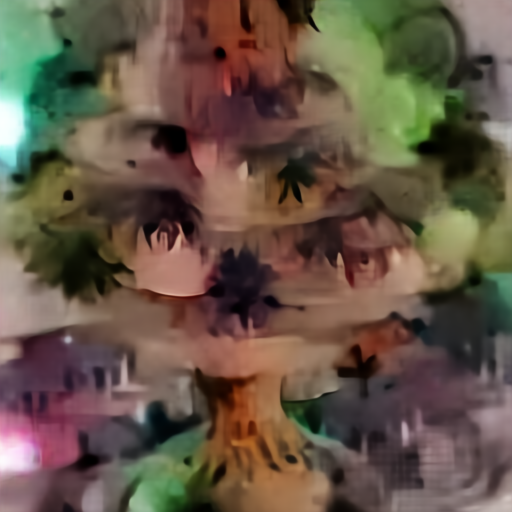



[26-08-2021 10:34:37][INF] => Progress: 100/400 (25.00%)
[26-08-2021 10:34:37][INF] => Progress: 101/400 (25.25%)
[26-08-2021 10:34:38][INF] => Progress: 102/400 (25.50%)
[26-08-2021 10:34:39][INF] => Progress: 103/400 (25.75%)
[26-08-2021 10:34:39][INF] => Progress: 104/400 (26.00%)
[26-08-2021 10:34:40][INF] => Progress: 105/400 (26.25%)
[26-08-2021 10:34:40][INF] => Progress: 106/400 (26.50%)
[26-08-2021 10:34:41][INF] => Progress: 107/400 (26.75%)
[26-08-2021 10:34:42][INF] => Progress: 108/400 (27.00%)
[26-08-2021 10:34:42][INF] => Progress: 109/400 (27.25%)
[26-08-2021 10:34:43][INF] => Progress: 110/400 (27.50%)
[26-08-2021 10:34:44][INF] => Progress: 111/400 (27.75%)
[26-08-2021 10:34:44][INF] => Progress: 112/400 (28.00%)
[26-08-2021 10:34:45][INF] => Progress: 113/400 (28.25%)
[26-08-2021 10:34:45][INF] => Progress: 114/400 (28.50%)
[26-08-2021 10:34:46][INF] => Progress: 115/400 (28.75%)
[26-08-2021 10:34:47][INF] => Progress: 116/400 (29.00%)
[26-08-2021 10:34:47][INF] =>

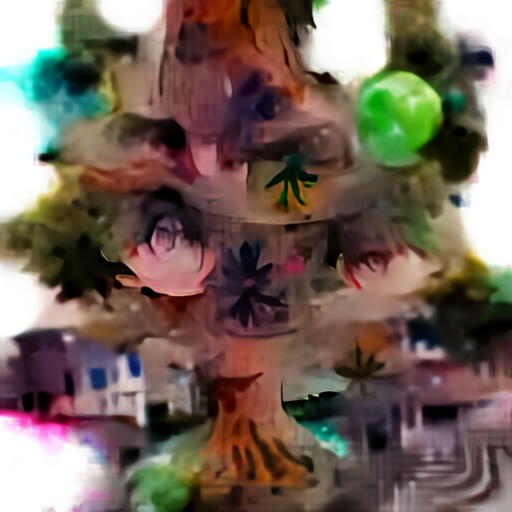



[26-08-2021 10:35:40][INF] => Progress: 200/400 (50.00%)
[26-08-2021 10:35:41][INF] => Progress: 201/400 (50.25%)
[26-08-2021 10:35:41][INF] => Progress: 202/400 (50.50%)
[26-08-2021 10:35:42][INF] => Progress: 203/400 (50.75%)
[26-08-2021 10:35:43][INF] => Progress: 204/400 (51.00%)
[26-08-2021 10:35:43][INF] => Progress: 205/400 (51.25%)
[26-08-2021 10:35:44][INF] => Progress: 206/400 (51.50%)
[26-08-2021 10:35:44][INF] => Progress: 207/400 (51.75%)
[26-08-2021 10:35:45][INF] => Progress: 208/400 (52.00%)
[26-08-2021 10:35:46][INF] => Progress: 209/400 (52.25%)
[26-08-2021 10:35:46][INF] => Progress: 210/400 (52.50%)
[26-08-2021 10:35:47][INF] => Progress: 211/400 (52.75%)
[26-08-2021 10:35:48][INF] => Progress: 212/400 (53.00%)
[26-08-2021 10:35:48][INF] => Progress: 213/400 (53.25%)
[26-08-2021 10:35:49][INF] => Progress: 214/400 (53.50%)
[26-08-2021 10:35:49][INF] => Progress: 215/400 (53.75%)
[26-08-2021 10:35:50][INF] => Progress: 216/400 (54.00%)
[26-08-2021 10:35:51][INF] =>

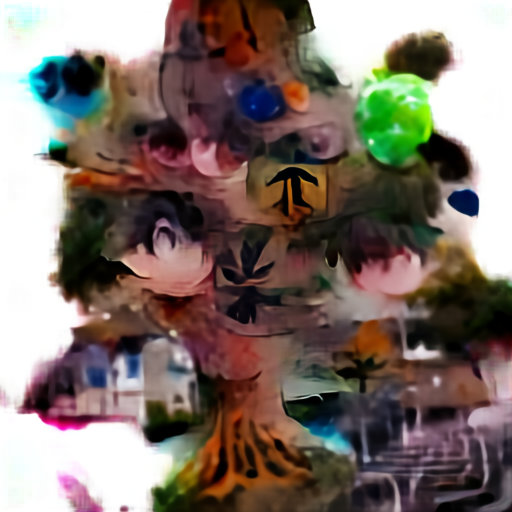



[26-08-2021 10:36:44][INF] => Progress: 300/400 (75.00%)
[26-08-2021 10:36:44][INF] => Progress: 301/400 (75.25%)
[26-08-2021 10:36:45][INF] => Progress: 302/400 (75.50%)
[26-08-2021 10:36:46][INF] => Progress: 303/400 (75.75%)
[26-08-2021 10:36:46][INF] => Progress: 304/400 (76.00%)
[26-08-2021 10:36:47][INF] => Progress: 305/400 (76.25%)
[26-08-2021 10:36:48][INF] => Progress: 306/400 (76.50%)
[26-08-2021 10:36:48][INF] => Progress: 307/400 (76.75%)
[26-08-2021 10:36:49][INF] => Progress: 308/400 (77.00%)
[26-08-2021 10:36:49][INF] => Progress: 309/400 (77.25%)
[26-08-2021 10:36:50][INF] => Progress: 310/400 (77.50%)
[26-08-2021 10:36:51][INF] => Progress: 311/400 (77.75%)
[26-08-2021 10:36:51][INF] => Progress: 312/400 (78.00%)
[26-08-2021 10:36:52][INF] => Progress: 313/400 (78.25%)
[26-08-2021 10:36:53][INF] => Progress: 314/400 (78.50%)
[26-08-2021 10:36:53][INF] => Progress: 315/400 (78.75%)
[26-08-2021 10:36:54][INF] => Progress: 316/400 (79.00%)
[26-08-2021 10:36:55][INF] =>

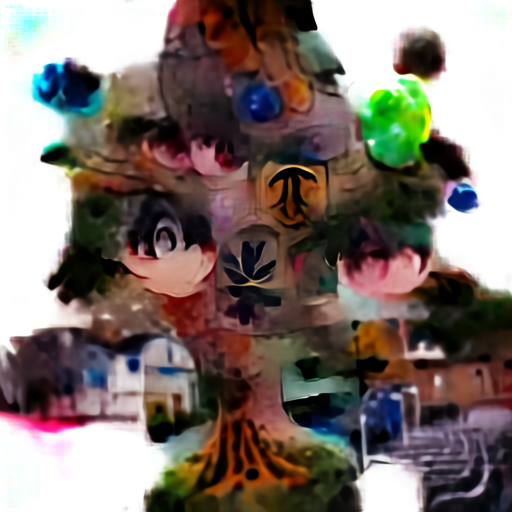



[26-08-2021 10:37:48][INF] => Loss: None


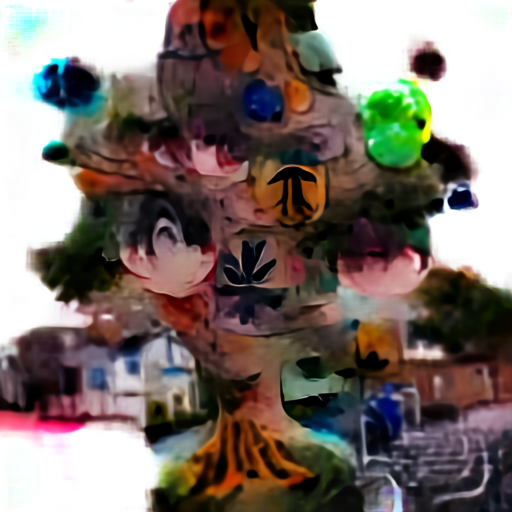



[26-08-2021 10:37:48][INF] => Complete!


127.0.0.1 - - [26/Aug/2021 10:37:49] "GET /content/result.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Aug/2021 10:37:49] "GET /content/result.png HTTP/1.1" 200 -


In [11]:
app.run()